# Modelo de Vis√£o Computacional


## Introdu√ß√£o

A id√©ia geral do projeto para a Mottu era a de escanear o p√°tio com um rob√¥ que utilizasse IoT, para gerar uma esp√©cie de planta baixa do p√°tio (pensando que cada p√°tio pode ter uma configura√ß√£o espacial diferente). A partir dessa planta baixa o ADM da Mottu poderia delimitar zonas de dep√≥sito das motocicletas manualmente, que se comunicariam com o sistema via tags BLE (Bluetooth Low Energy) em cada uma das motos.

Ex de panta baixa que esperamos gerar: (as √°reas em vermelho representam a delimita√ß√£o de zonas)

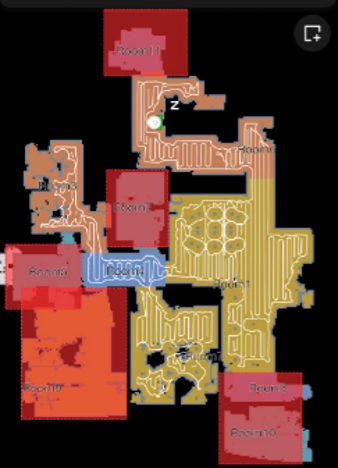


Inicialmente foi um pouco dif√≠cil pensar em aplica√ß√µes para vis√£o computacional nesse projeto que fizessem sentido com o nosso planejamento (al√©m de uma pura an√°lise de dados), mas depois de dar uma pensada eu cheguei na conclus√£o de que seria interessante utilizar a CV como um complemento que estivesse alinhado com o plano original.

Portanto, a ideia deste projeto √© usar a Vis√£o Computacional como uma ferramenta de an√°lise pr√©via ou de suporte ao planejamento do p√°tio, ajudando o ADM a tomar decis√µes mais informadas antes de configurar as zonas no "Editor de P√°tio" para posicionamento estrat√©gico das zonas, basicamente um modelo que analisa o p√°tio e sugere √°reas para o posicionamento das zonas.

Problema Real que o Prot√≥tipo CV Resolve (neste contexto auxiliar):
- Como um administrador pode ter uma vis√£o inicial da densidade e distribui√ß√£o t√≠pica de motos em um p√°tio antes de desenhar as zonas no sistema FLEET?
- Como identificar "gargalos" ou √°reas de alta concentra√ß√£o que podem necessitar de aten√ß√£o especial no layout das zonas?

Justificativa da Aplica√ß√£o de CV:
- A CV pode processar imagens (est√°ticas ou de um v√≠deo curto) de um p√°tio para identificar automaticamente as motos e suas localiza√ß√µes relativas.
- Essa an√°lise visual pode gerar insights (mapas de calor de densidade, sugest√µes de agrupamentos) que complementam o mapa de planta baixa do rob√¥, oferecendo uma camada de "intelig√™ncia visual" para o planejamento.

## Prepara√ß√£o do Dataset

- Meta Inicial (para um primeiro ciclo de treino): 300 a 400 imagens diversas. O objetivo aqui √© passar por todo o pipeline (coleta, anota√ß√£o, treino, avalia√ß√£o inicial) para identificar gargalos e ter um primeiro modelo funcional, mesmo que com limita√ß√µes.

- Foco em Inst√¢ncias: Pelo menos algumas centenas de motos anotadas no total (500 imagens com uma m√©dia de 1-2 motos por imagem = 500-1000 inst√¢ncias).

- Estrat√©gia de Coleta: Buscar variedade de √¢ngulos, ilumina√ß√£o e cen√°rios.

- Ferramenta de Anota√ß√£o: https://www.makesense.ai/

- Processo de Anota√ß√£o: Anotar as imagens desenhando bounding boxes ao redor de cada moto, e definir uma classe "MB" (MotorBike).

- Divis√£o do Dataset: dados de treino, valida√ß√£o e teste.

- Fontes:

 - http://velastin.dynu.com/videodatasets/UrbanMotorbike/mb10000.htm
 - https://www.kaggle.com/datasets/zwartfreak/bike-images
 - Imagens diversas da internet coletadas e anotadas manualmente

## Descri√ß√£o do Dataset

- N√∫mero de Imagens: 852 imagens que atrav√©s de augmentation (flips, rota√ß√£o, brilho, exposi√ß√£o, blur e ru√≠do) geraram "2 vers√µes de cada", resultando em 1704 imagens no total, ajudando o modelo a generalizar melhor e a ser mais robusto a diferentes condi√ß√µes do mundo real, simulando uma variedade maior de dados a partir das imagens originais.

- Formato YOLO v5 PyTorch e arquivos .txt para as anota√ß√µes.

- Divis√£o em pastas train (702 imagens), test (50 imagens, utilizadas AP√ìS o treinamento para uma avalia√ß√£o final do modelo) e valid (100 imagens, utilizadas DURANTE o treinamento para verifica√ß√£o imparcial do modelo).

- Data.yml: aponta para os caminhos das pastas train, valid, e test, define o n√∫mero de classes (nesse caso uma s√≥, a classe MB) para associar as imagens e suas respectivas labels.

In [ ]:
# Ex. Data.yml:

train: train/images
val: valid/images
test: test/images

nc: 1
names: ['MB']

# Ex. label:
0 0.491796875 0.456640625 0.8265625 0.83828125

## Configura√ß√£o inicial:

In [ ]:
!pip install ultralytics -q
!pip install opencv-python -q
!pip install scikit-learn -q

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.0/1.0 MB 56.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13.8/13.8 MB 95.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24.6/24.6 MB 86.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

Instalando a lib da Ultralytics para YOLOv8 (modelo pr√©-treinado de vis√£o computacional).

Importante mencionar:
O dataset foi construido no formato "YOLO v5 Pytorch" por ser o mais compat√≠vel com o Makesense.ai, por√©m o modelo YOLO v8 foi escolhido por duas raz√µes:

*   O formato do YOLO v5 √© totalmente compat√≠vel com o YOLO v8, n√£o apresentando impedimento para o treinamento sem necesscidade de convers√£o
*   Facilidade de uso, maior precis√£o e performance (necess√°rio pelo uso limitado de GPU do plano free do collab)



In [ ]:
import torch
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from google.colab import drive

drive.mount('/content/drive')

Creating new Ultralytics Settings v0.0.6 file ‚úÖ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Mounted at /content/drive


In [ ]:
# Confirmando que estamos usando a GPU:

if torch.cuda.is_available():
    gpu_info = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_info}")

Configura√ß√£o das vari√°veis de ambiente:

In [ ]:
GOOGLE_DRIVE_BASE_PATH = '/content/drive/MyDrive/Colab_Notebooks'
PROJECT_FOLDER_NAME = 'fleet_cv'
project_base_path = os.path.join(GOOGLE_DRIVE_BASE_PATH, PROJECT_FOLDER_NAME)
dataset_yolo_path = os.path.join(project_base_path, 'datasets/yolo_motorcycle_detector/')
data_yaml_path = os.path.join(dataset_yolo_path, 'data.yaml')
trained_models_dir = os.path.join(project_base_path, 'trained_models/yolo_detector/')

Configura√ß√£o do comando de treinamento do YOLO v8:

In [ ]:
MODEL_TO_TRAIN = 'yolov8n.pt' # nome do modelo (yolov8 nano, pra agilizar os testes nessa fase inicial)
NUM_EPOCHS = 30 # n√∫mero de vezes que o modelo vai ver o dataset completo, a cada √©poca o modelo pega m√©tricas e reajusta os parametros internos para melhorar a acur√°cia
IMAGE_SIZE = 640 # tamanho para o qual as imagens s√£o redimensionadas, no caso 640x640 pixels
BATCH_SIZE = 16 # n√∫mero de imagens que o modelo processa de uma vez (ou seja se o conjunto de treino possui 702 imagens, ele vai precisar de 44 itera√ß√µes para percorrer todo o set de treino), testei entre 8-16 para evitar problemas de mem√≥ria com a GPU
EXPERIMENT_NAME = 'yolov8n_motorbike_detector_run1' # nome qualquer

In [ ]:
!yolo train model={MODEL_TO_TRAIN} data="{data_yaml_path}" epochs={NUM_EPOCHS} imgsz={IMAGE_SIZE} batch={BATCH_SIZE} project="{trained_models_dir}" name="{EXPERIMENT_NAME}"

100% 6.25M/6.25M [00:00<00:00, 388MB/s]
Ultralytics 8.3.141 üöÄ Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab_Notebooks/fleet_cv/datasets/yolo_motorcycle_detector/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8n_motorbike_detector_run1, nbs=64, nms=Fa

## An√°lise dos resultados iniciais

Interpreta√ß√£o do output:

In [ ]:
results_csv_path = '/content/drive/MyDrive/Colab_Notebooks/fleet_cv/trained_models/yolo_detector/yolov8n_motorbike_detector_run1/results.csv'

In [ ]:
df_results = pd.read_csv(results_csv_path)
df_results.columns = df_results.columns.str.strip()

In [ ]:
print("Colunas:", df_results.columns.tolist())

Colunas: ['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


Explica√ß√£o das colunas relevantes para a an√°lise:
- Epoch: O n√∫mero da √©poca atual
- train/box_loss: Perda da Caixa Delimitadora, ou seja, o qu√£o erradas est√£o as coordenadas que o modelo previu COMPARADAS COM AS ANOTA√á√ïES REAIS DOS DADOS TREINO, via-de-regra quanto menor o n√∫mero melhor
- train/cls_loss: Perda da classifica√ß√£o, se o modelo classificou errado o conte√∫do de uma caixa delimitadora como "MB" (motorbike), ou seja, o modelo analisa apenas o que est√° dentro da bounding box
- metrics/precision(B): M√©trica de precis√£o calculada sobre o conjunto de valida√ß√£o ap√≥s o treinamento daquela √©poca (o B √© um parametro interno do modelo que significa que √© para a tarefa espec√≠fica de detec√ß√£o de bounding boxes)
- metrics/recall(B): M√©trica de recall calculada sobre o conjunto de valida√ß√£o
- metrics/mAP50(B): Mean Average Precision, com um IoU (Intersection over Union) de 0.50, isso significa que uma detec√ß√£o √© contada como correta se a sobreposi√ß√£o entre a caixa prevista e a caixa real for de pelo menos 50% (e a classe for correta)
- metrics/mAP50-95(B): Basicamente o mesmo da coluna metrics/mAP50(B), por√©m com um IoU de 50 a 95%, o que exige que para um score alto nessa m√©trica, as bounding boxes que o modelo previu sejam muito mais precisas
- val/box_loss: similar √† coluna train/box_loss, por√©m em compara√ß√£o COM OS VALORES DO CONJUNTO DE VALIDA√á√ÉO
- val/cls_loss: similar √† coluna train/cls_loss, por√©m em compara√ß√£o COM OS VALORES DO CONJUNTO DE VALIDA√á√ÉO

In [ ]:
df_results

epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0       1   28.5675         1.36326         2.37549         1.74886   
1       2   52.4712         1.44585         2.19587         1.83382   
2       3   75.6425         1.54009         2.08045         1.86220   
3       4   99.7984         1.53709         2.00175         1.85364   
4       5  124.5950         1.56599         1.90451         1.89722   
5       6  147.6430         1.50859         1.85535         1.84547   
6       7  172.8750         1.49955         1.78490         1.83572   
7       8  198.0870         1.43090         1.68166         1.78695   
8       9  221.2700         1.42913         1.63305         1.77061   
9      10  246.3020         1.42303         1.60662         1.75712   
10     11  270.9210         1.40532         1.57013         1.75018   
11     12  294.4150         1.37670         1.55264         1.70388   
12     13  319.5160         1.33505         1.49785         1.70024   
13     14  344.4690         1.38658         1.52010         1.70608   
14     15  368.0600         1.31568         1.45439         1.66938   
15     16  392.7700         1.33874         1.39405         1.65746   
16     17  417.6560         1.31114         1.30680         1.65723   
17     18  441.0760         1.28152         1.32440         1.62223   
18     19  465.6600         1.24004         1.28923         1.60871   
19     20  490.6900         1.23488         1.31202         1.60942   
20     21  517.7640         1.19471         1.19239         1.71855   
21     22  541.1120         1.20582         1.12646         1.72519   
22     23  565.1630         1.13118         1.01897         1.65123   
23     24  587.1960         1.09450         0.98579         1.61130   
24     25  611.6500         1.07249         0.95440         1.59024   
25     26  635.8780         1.05052         0.90582         1.55723   
26     27  658.7100         1.00876         0.87315         1.51227   
27     28  683.1890         0.99327         0.85606         1.50919   
28     29  707.7110         0.96754         0.82764         1.48727   
29     30  730.6730         0.93835         0.75933         1.46554   

    metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0                0.76335            0.10580           0.35325   
1                0.41952            0.43443           0.32399   
2                0.27021            0.25410           0.13740   
3                0.22871            0.22951           0.12301   
4                0.58882            0.36885           0.35361   
5                0.55488            0.43443           0.45059   
6                0.60409            0.45902           0.51074   
7                0.56981            0.48361           0.48935   
8                0.56699            0.48298           0.46791   
9                0.43880            0.34426           0.35632   
10               0.60799            0.45767           0.51292   
11               0.68159            0.53279           0.58356   
12               0.39599            0.43443           0.32469   
13               0.79069            0.52641           0.61853   
14               0.84148            0.54098           0.64172   
15               0.69479            0.53279           0.61621   
16               0.84364            0.57496           0.66185   
17               0.85472            0.58197           0.67490   
18               0.69860            0.46721           0.51180   
19               0.80879            0.63934           0.68447   
20               0.80701            0.60656           0.68711   
21               0.85327            0.57200           0.66130   
22               0.77939            0.59836           0.70381   
23               0.81509            0.63934           0.71515   
24               0.82161            0.64754           0.71733   
25               0.80462            0.61475           0.72563   
26               0.81119            0.62295    

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
epochs = df_results['epoch']

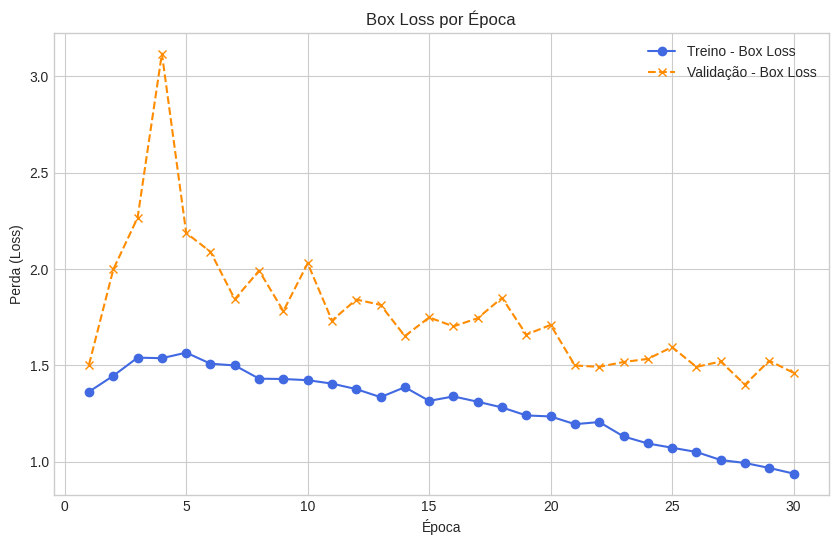

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, df_results['train/box_loss'], label='Treino - Box Loss', color='royalblue', marker='o', linestyle='-')
plt.plot(epochs, df_results['val/box_loss'], label='Valida√ß√£o - Box Loss', color='darkorange', marker='x', linestyle='--')
plt.title('Box Loss por √âpoca')
plt.xlabel('√âpoca')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()

O gr√°fico de box loss basciamente mostra o seguinte:
- linha azul: o qu√£o bem o modelo est√° acertando a posi√ß√£o e o tamanho das boxes nas imagens que ele est√° usando pra treinar (lembrando que quanto menor o valor, menor a taxa de erro, ou seja, o modelo acertou mais)

- linha laranja: o qu√£o bem o modelo consegue generaliza essa habilidade tentando acertar a posi√ß√£o e o tamanho das boxes em imagens que ele nunca viu antes, no caso nosso conjunto de valida√ß√£o


Comportamento da loss:
- nas √©pocas 1-5 durante o treino e a valida√ß√£o o modelo teve uma taxa maior de erros, com um pico acentuado durante a valida√ß√£o da √©poca 4, pelos padr√µes de outros modelos que eu vi, eu imagino que isso n√£o seja incomum j√° que no come√ßo do processo o modelo faz grandes ajustes nos pesos para "explorar as possiblidades" enquanto ele n√£o generaliza bem

- nas √©pocas 6-25 o comportamento das duas linhas padroniza, levando a uma melhora gradual e menos loss (apesar de ainda terem varia√ß√µes mais acentuadas na etapa de valida√ß√£o, o fato da linha n√£o tem uma subida constante, o que √© um bom sinal)

- nas √©pocas 26-30 apesar da instabilidade inicial e das flutua√ß√µes ambas linhas apresentam um padr√£o descendente constante e gradual o que indica que o modelo est√° aprendendo a reconhe√ßer os padr√µes

IMPORTANTE: um bom sinal tamb√©m √© que o fato das duas linhas apresentarem um padr√£o parecido indica que o modelo n√£o est√° com overfitting, se fosse esse o caso a tendencia era a linha de teste permanecer num padr√£o descendente enquanto a linha da valida√ß√£o estaria ascendendo constantemente (a val/box_loss parece ter estabilizado um pouco mais ali perto do final, mas n√£o parece ser uma subida muito preocupante)



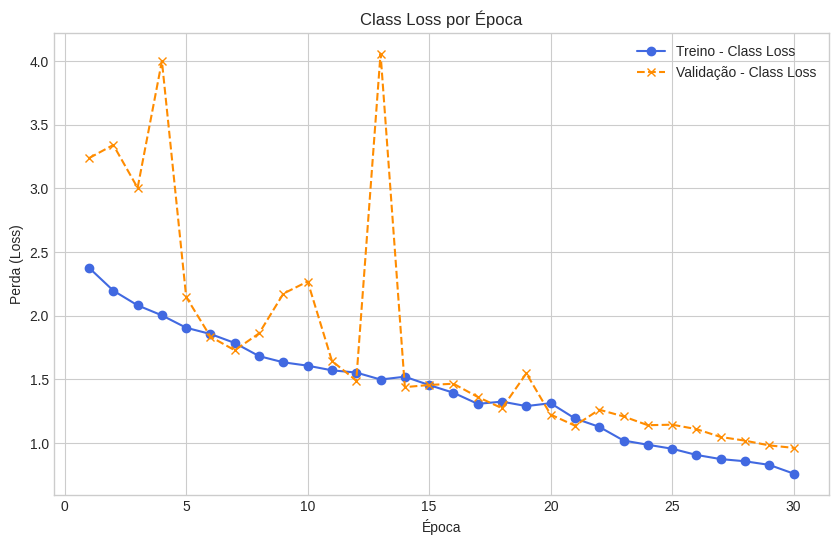

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, df_results['train/cls_loss'], label='Treino - Class Loss', color='royalblue', marker='o', linestyle='-')
plt.plot(epochs, df_results['val/cls_loss'], label='Valida√ß√£o - Class Loss', color='darkorange', marker='x', linestyle='--')
plt.title('Class Loss por √âpoca')
plt.xlabel('√âpoca')
plt.ylabel('Perda (Loss)')
plt.legend()
plt.grid(True)
plt.show()

O gr√°fico de class loss vai indicar o qu√£o bem o modelo, depois de delimitar a bounding box, consegue identificar o que est√° dentro dela como sendo uma moto (MB) ou n√£o. (valor menor = melhor)

Treino:
- as √©pocas 1-7 indiciam uma queda r√°pida no valor da loss o que indica que o modelo aprendeu relativamente r√°pido as caracteristicas mais √≥bvias para conseguir identificar uma moto

- √©pocas 8-30 continuam com o padr√£o de diminui√ß√£o gradual, o que significa que o modelo est√° ficando cada vez melhor em classificar corretamente as motos no conjunto de dados que ele est√° usando para aprender

Valida√ß√£o:
- √©pocas 1-15 mostram picos de instabilidade consider√°veis no inicio, com um pico enorme entre as √©pocas 4 e 5, ultrapassando 4.0 e um segundo entre as √©pocas 13-14, tamb√©m acima de 4.0. Isso pode ser por causa de ajustes nos pesos que acabam n√£o generalizando bem para imagens nunca vistas antes em um modelo que ainda est√° imaturo

- j√° as √©pocas 16-30 mostram uma boa recupera√ß√£o e a converg√™ncia com a linha de treino (muito positivo), em alguns momentos apresentando at√© uma taxa de loss menor do que a de treino, ou seja, o modelo conseguiu se recuperar e aprender a generalizar sua capacidade de classifica√ß√£o para o conjunto de valida√ß√£o

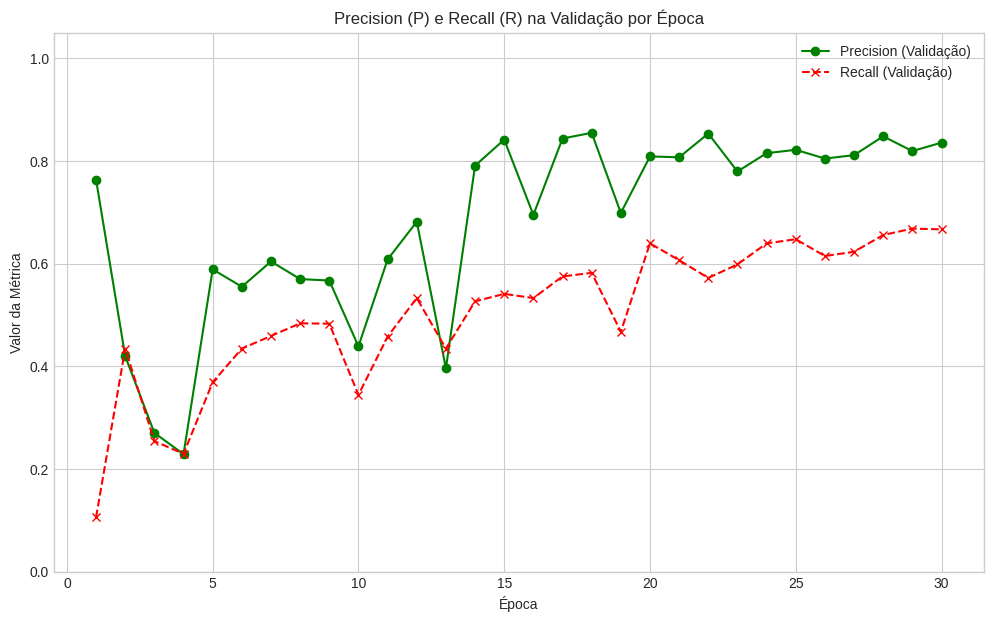

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(epochs, df_results['metrics/precision(B)'], label='Precision (Valida√ß√£o)', color='green', marker='o', linestyle='-')
plt.plot(epochs, df_results['metrics/recall(B)'], label='Recall (Valida√ß√£o)', color='red', marker='x', linestyle='--')
plt.title('Precision (P) e Recall (R) na Valida√ß√£o por √âpoca')
plt.xlabel('√âpoca')
plt.ylabel('Valor da M√©trica')
plt.legend()
plt.grid(True)
plt.ylim(0, 1.05)
plt.show()

Inicialmente tinha feito dois gr√°ficos separados para analisar precis√£o e recall mas eu percebi que o recall dava uns insights importantes sobre a precis√£o ent√£o optei por juntar os dois. A linha de precis√£o (verde) basicamente indica quantas vezes por √©poca o modelo disse "isso √© uma moto" e estava certo, quanto maior o valor de precis√£o, mais vezes o modelo estava correto. J√° a linha de recall (vermelha), indica quantas motos o modelo conseguiu encontrar de todas que existiam na imagem.

-√©poca 1 come√ßa com uma precis√£o supreendetemente alta em torno de 76%, mas um recall baix√≠ssimo com cerca de 10%, ou seja o modelo encontrou s√≥ 10% das motos das imagens, mas as que ele "se arriscou" a dizer que eram de fato uma moto estavam corretas 76% das vezes. Nesse est√°gio inicial o modelo parece estar operando de uma maneira bem conservadora, j√° que ele ainda n√£o aprendeu bem as caracteristicas que definem uma moto, e s√≥ faz uma detec√ß√£o quando tem um grau de confian√ßa muito alto.

- √©pocas 2-4 a precis√£o despenca atingindo o ponto mais baixo de cerca de 23% na √©poca 4, enquanto o recall come√ßa a aumentar um pouco, isso coincide com a fase de ajustes dos pesos dos gr√°ficos anteriores e mostra uma consistencia nesse sentido de uma fase de adapta√ß√£o durante a valida√ß√£o nesse per√≠odo. O modelo ainda est√° meio "perdido" tentando aprender

- nas √©pocas 5-13 as m√©tricas v√£o se recuperando um pouco mais ainda continuam muito vol√°teis e com n√≠veis medianos baixos, e fica oscilando, quando um sobre o outro pode n√£o acompanhar ou ter uma queda. O modelo aidna est√° numa fase de explora√ß√£o e ajustes, essa oscila√ß√£o pode ser explicada pelo modelo tentando ser mais "corajoso" pra tentar achar mais motos, mas com o custo de errar mais

- na √©poca 14 parece que temos um ponto de virada, a precis√£o da um salto enorme, pra cerca de 80% e o recall pra mais de 50%, modelo parece ter encontrado um caminho de aprendizado mais eficaz

- e finalmente, nas √©pocas 15-30 as curvas v√£o aumentando gradualmente at√© chegar no seu n√≠vel mais alto e est√°vel, o modelo parece estar mais preciso, mas ainda tem o recall como sendo a parte mais dificil para ele

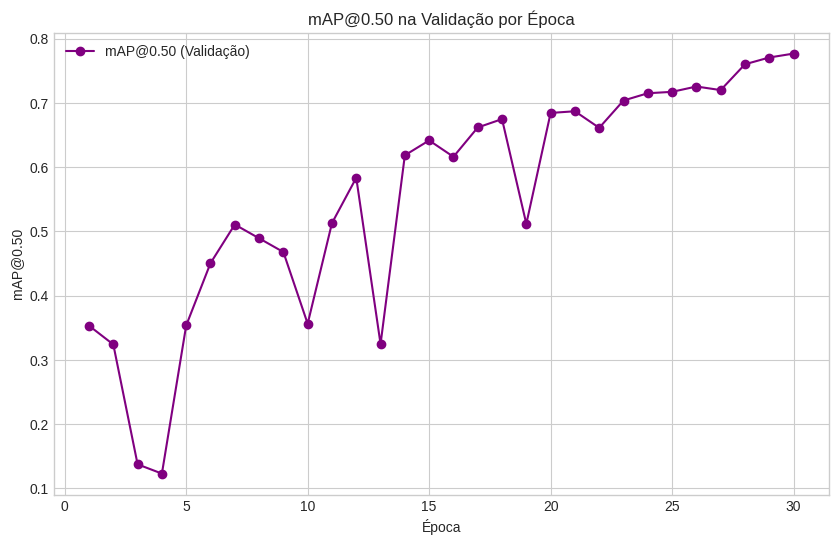

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, df_results['metrics/mAP50(B)'], label='mAP@0.50 (Valida√ß√£o)', color='purple', marker='o')
plt.title('mAP@0.50 na Valida√ß√£o por √âpoca')
plt.xlabel('√âpoca')
plt.ylabel('mAP@0.50')
plt.legend()
plt.grid(True)
plt.show()

Esse √© um dos gr√°ficos mais importantes j√° que o mean average precision (mAP) √© uma m√©trica chave que resume a performance geral do detector. Lembrando que para um resultado positivo dessa m√©trica o modelo precisa ter uma precis√£o de pelo menos 50% entre a box prevista e a box que foi anotada manualmente, al√©m de ter classificado o objeto dentro da box corretamente

- nas √©pocas 1-4, novamente fase de ajustes de pesos, n√£o vou me alongar muito

- nas √©pocas 5-7 temos uma subida que indicia que o modelo come√ßou a aprender bem, j√° que um mAP@0.50 acima de 0.5 significa que, em m√©dia, o modelo esta acertando mais da metade das detec√ß√µes com uma sobreposi√ß√£o entre caixa prevista/real aceit√°vel, isso acontece provavelmente pq a precis√£o e o recall come√ßaram a melhorar tamb√©m

- nas √©pocas 8-20 temos uma melhora gradual, mesmo que com alguns picos de volatilidade, o pico na √©poca 12 coincide com a fase em que o recall e a precis√£o tiveram valores bons simultaneamente, impulsionando o modelo para cima

- nas √©pocas 21-30 temos uma subida mais consistente, e bem mais gradual, que indica  uma fase final de otimiza√ß√£o. interessante que o fato da reta continuar subindo at√© o final sugere que talvez ainda houvesse um espa√ßo pra melhora com mais algumas √©pocas, mas pra essa primeira fase um mAP@0.50 de aproximadamente 77% ta bem s√≥lido

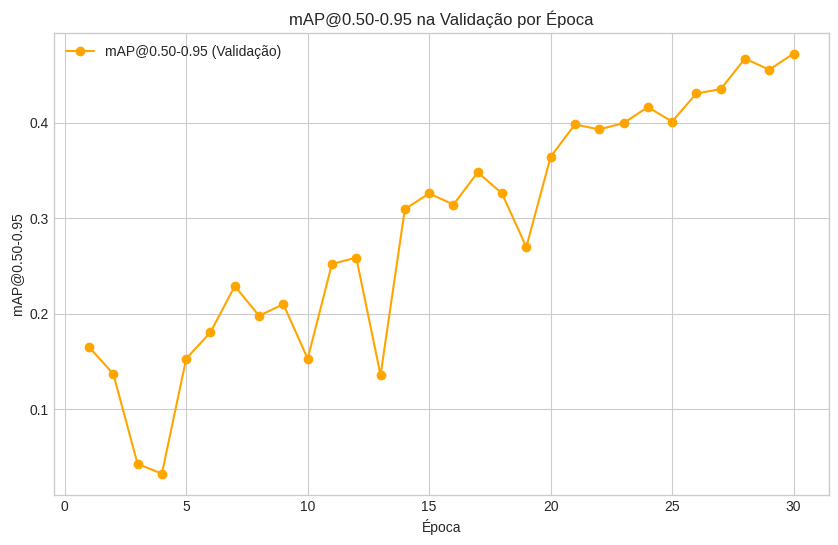

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, df_results['metrics/mAP50-95(B)'], label='mAP@0.50-0.95 (Valida√ß√£o)', color='orange', marker='o')
plt.title('mAP@0.50-0.95 na Valida√ß√£o por √âpoca')
plt.xlabel('√âpoca')
plt.ylabel('mAP@0.50-0.95')
plt.legend()
plt.grid(True)
plt.show()

Gr√°fico de mAP@0.50-0.95, ou seja, j√° exige uma precis√£o muito maior na localiza√ß√£o, j√° que calcula a m√©dia do mAP para um IoU de 50 at√© 95% o score depende das caixas estarem quase perfeitamente alinhadas com os objetos. Se parece muito com o gr√°fico anterior j√° que ambas as m√©tricas (mAP@0.50 e mAP@0.50-0.95) medem a performance geral da detec√ß√£o, se o modelo estiver aprendendo como deveria, o comportamento esperado √© que ambas as m√©tricas sigam uma tend√™ncia similar de subida ao longo das √©pocas, por√©m com uma diferen√£ fundamental, os valores absolutos (eixo y) do mAP@0.50-0.95 s√£o significativamente mais baixos que os do mAP@0.50.

- as √©pocas 1-20 seguem basicamente o mesmo padr√£o de comportamento analisado anteriormente por√©m entre valores de 10/40%, nenhuma observa√ß√£o adicional √© necess√°ria

- ja as ultimas 9 √©pocas (21-30) √© a fase onde o modelo realmente refina a precis√£o das suas caixas delimitadoras. Atingir um mAP@0.50-0.95 de cerca de 47% com um modelo nano em 30 √©pocas est√° dentro do padr√£o esperado para uma primeira entrega, mas tem espa√ßo para melhora significativa.

## Conclus√£o da primeira etapa

In [ ]:
# Determinando a √©poca com os melhores scores overall

# Melhor mAP50-95
best_map50_95_epoch = df_results['metrics/mAP50-95(B)'].idxmax()
best_map50_95_value = df_results['metrics/mAP50-95(B)'].max()
actual_epoch_map50_95 = df_results.loc[best_map50_95_epoch, 'epoch']

print(f"\nMelhor metrics/mAP50-95: {best_map50_95_value:.4f} na √âpoca DataFrame (√≠ndice {best_map50_95_epoch}), √âpoca Real ~{int(actual_epoch_map50_95)}")
print(f"Valores nessa √©poca: \n{df_results.iloc[best_map50_95_epoch]}")

# Melhor mAP50
best_map50_epoch = df_results['metrics/mAP50(B)'].idxmax()
best_map50_value = df_results['metrics/mAP50(B)'].max()
actual_epoch_map50 = df_results.loc[best_map50_epoch, 'epoch']

print(f"\nMelhor metrics/mAP50(B): {best_map50_value:.4f} na √âpoca DataFrame (√≠ndice {best_map50_epoch}), √âpoca Real ~{int(actual_epoch_map50)}")
print(f"Valores nessa √©poca: \n{df_results.iloc[best_map50_epoch]}")

# Melhor Precision
best_precision_epoch = df_results['metrics/precision(B)'].idxmax()
best_precision_value = df_results['metrics/precision(B)'].max()
actual_epoch_precision = df_results.loc[best_precision_epoch, 'epoch']

print(f"\nMelhor metrics/precision(B): {best_precision_value:.4f} na √âpoca DataFrame (√≠ndice {best_precision_epoch}), √âpoca Real ~{int(actual_epoch_precision)}")
print(f"Valores nessa √©poca: \n{df_results.iloc[best_precision_epoch]}")

# Melhor Recall
best_recall_epoch = df_results['metrics/recall(B)'].idxmax()
best_recall_value = df_results['metrics/recall(B)'].max()
actual_epoch_recall = df_results.loc[best_recall_epoch, 'epoch']

print(f"\nMelhor metrics/recall(B): {best_recall_value:.4f} na √âpoca DataFrame (√≠ndice {best_recall_epoch}), √âpoca Real ~{int(actual_epoch_recall)}")
print(f"Valores nessa √©poca: \n{df_results.iloc[best_recall_epoch]}")


Melhor metrics/mAP50-95: 0.4725 na √âpoca DataFrame (√≠ndice 29), √âpoca Real ~30
Valores nessa √©poca: 
epoch                    30.000000
time                    730.673000
train/box_loss            0.938350
train/cls_loss            0.759330
train/dfl_loss            1.465540
metrics/precision(B)      0.835610
metrics/recall(B)         0.666650
metrics/mAP50(B)          0.776890
metrics/mAP50-95(B)       0.472480
val/box_loss              1.461290
val/cls_loss              0.961340
val/dfl_loss              1.908280
lr/pg0                    0.000086
lr/pg1                    0.000086
lr/pg2                    0.000086
Name: 29, dtype: float64

Melhor metrics/mAP50(B): 0.7769 na √âpoca DataFrame (√≠ndice 29), √âpoca Real ~30
Valores nessa √©poca: 
epoch                    30.000000
time                    730.673000
train/box_loss            0.938350
train/cls_loss            0.759330
train/dfl_loss            1.465540
metrics/precision(B)      0.835610
metrics/recall(B)         0.

De maneira geral, analisando as m√©tricas, a melhor √©poca para prosseguir com o fine tuning do modelo √© a √©poca 30, pois:

- metrics/mAP50-95(B): A m√©trica mais importante para determinar o "melhor" modelo, pois √© a mais rigorosa, exigindo boa classifica√ß√£o e localiza√ß√£o precisa em v√°rios n√≠veis de sobreposi√ß√£o

- metrics/mAP50(B): Indica um bom desempenho geral com uma exig√™ncia de sobreposi√ß√£o mais relaxada (ambas mAP atingiram o pico na mesma √©poca)

- O pico de Precis√£o (0.8547) ocorreu na √âpoca 18. No entanto, nessa mesma √âpoca 18:
 - O Recall era 0.5820 (significativamente menor que o pico de Recall)
 - mAP50(0.6749) e metrics/mAP50-95(0.3259), bem menores que o pico

- O melhor recall aconteceu na √©poca 29, que tamb√©m tinha bons valores de precis√£o, mPA0.50 e mPA0.50-0.95, mas no geral a √©poca 30 se mostrou ligeiramente superior, mesmo sacrificando um pouco da preciss√£o em nome de uma taxa de recall maior.

Carregando a melhor √©poca escolhida pelo YOLO:

Por mais que o YOLO analise as m√©tricas por si s√≥ e escolha o melhor modelo, eu achei interessante fazer essa an√°lise cruzada pra tentar entender como o YOLO determinava isso, o que estava acontecendo no geral e comparar se o melhor modelo escolhido pelo YOLO (√©poca 30) coincidiria com a minha interpreta√ß√£o das m√©tricas

In [ ]:
path_to_best_pt = os.path.join(trained_models_dir, EXPERIMENT_NAME, 'weights/best.pt')

In [ ]:
model = YOLO(path_to_best_pt)
metrics = model.val(data=data_yaml_path, split='val', imgsz=640, save_json=False, save_hybrid=False)

# mAP50-95
map50_95 = metrics.box.map
print(f"mAP@0.50-0.95 (mAP geral): {map50_95:.4f}")

# mAP50
map50 = metrics.box.map50
print(f"mAP@0.50: {map50:.4f}")

# mAP75 (mAP com IoU de 0.75)
map75 = metrics.box.map75
print(f"mAP@0.75: {map75:.4f}")


print(metrics.results_dict.keys())

if 'metrics/precision(B)' in metrics.results_dict and 'metrics/recall(B)' in metrics.results_dict:
  precision_b = metrics.results_dict['metrics/precision(B)']
  recall_b = metrics.results_dict['metrics/recall(B)']
  print(f"Precision(B) do results_dict: {precision_b:.4f}")
  print(f"Recall(B) do results_dict: {recall_b:.4f}")

WARNING ‚ö†Ô∏è 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.144 üöÄ Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ‚úÖ (ping: 5.8¬±11.4 ms, read: 40.9¬±22.3 MB/s, size: 215.1 KB)


val: Scanning /content/drive/MyDrive/Colab_Notebooks/fleet_cv/datasets/yolo_motorcycle_detector/valid/labels.cache... 100 images, 22 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 7/7 [00:31<00:00,  4.46s/it]


                   all        100        122      0.836      0.667      0.776      0.471
Speed: 6.6ms preprocess, 274.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val3
mAP@0.50-0.95 (mAP geral): 0.4709
mAP@0.50: 0.7763
mAP@0.75: 0.4729
dict_keys(['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'fitness'])
Precision(B) do results_dict: 0.8356
Recall(B) do results_dict: 0.6667


## Analisando o melhor modelo

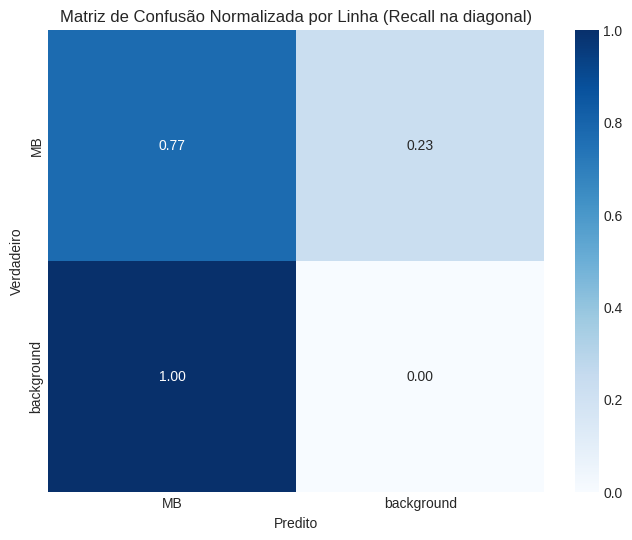

In [ ]:
conf_matrix_raw = metrics.confusion_matrix.matrix
class_plot_names = ['MB', 'background']

row_sums = conf_matrix_raw.sum(axis=1)
conf_matrix_normalized_row = conf_matrix_raw.astype('float') / (row_sums[:, np.newaxis] + 1e-6)
conf_matrix_normalized_row = np.nan_to_num(conf_matrix_normalized_row)

df_cm_normalized_row = pd.DataFrame(conf_matrix_normalized_row, index=class_plot_names, columns=class_plot_names)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm_normalized_row, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1)
plt.title('Matriz de Confus√£o Normalizada por Linha (Recall na diagonal)')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.show()

- O modelo demonstrou um Recall de 77% para a classe 'MB', ou seja, os 23% restantes das motos verdadeiras foram perdidas pelo detector ou classificadas incorretamente como background (falsos negativos)

- J√° na linha do true background, a normaliza√ß√£o mostra que 100% das inst√¢ncias contabilizadas nessa linha espec√≠fica como true background e que o modelo previu como 'MB' s√£o falsos positivos (modelo detectou uma moto onde n√£o deveria)

In [ ]:
metrics_test = model.val(
  data=data_yaml_path,
  split='test',
  imgsz=640,
  batch=16,
  project=os.path.join(project_base_path, 'trained_models/yolo_detector/'),
  name='best_pt_FINAL_EVAL_on_test_set',
  save_json=True,
  save_hybrid=False
)

WARNING ‚ö†Ô∏è 'save_hybrid' is deprecated and will be removed in in the future.
Ultralytics 8.3.144 üöÄ Python-3.11.12 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
val: Fast image access ‚úÖ (ping: 0.6¬±0.2 ms, read: 79.2¬±23.7 MB/s, size: 273.9 KB)


val: Scanning /content/drive/MyDrive/Colab_Notebooks/fleet_cv/datasets/yolo_motorcycle_detector/test/labels... 50 images, 11 backgrounds, 0 corrupt: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50/50 [00:00<00:00, 93.46it/s]

val: New cache created: /content/drive/MyDrive/Colab_Notebooks/fleet_cv/datasets/yolo_motorcycle_detector/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4/4 [00:16<00:00,  4.12s/it]


                   all         50         69       0.89      0.812      0.879      0.539
Speed: 8.1ms preprocess, 281.0ms inference, 0.0ms loss, 1.5ms postprocess per image
Saving /content/drive/MyDrive/Colab_Notebooks/fleet_cv/trained_models/yolo_detector/best_pt_FINAL_EVAL_on_test_set3/predictions.json...
Results saved to /content/drive/MyDrive/Colab_Notebooks/fleet_cv/trained_models/yolo_detector/best_pt_FINAL_EVAL_on_test_set3


In [ ]:
if hasattr(metrics_test, 'box') and metrics_test.box is not None:
  print(f"mAP@0.50-0.95 (Teste): {metrics_test.box.map:.4f}")
  print(f"mAP@0.50 (Teste): {metrics_test.box.map50:.4f}")

  precision_test = metrics_test.results_dict['metrics/precision(B)']
  recall_test = metrics_test.results_dict['metrics/recall(B)']
  print(f"Precision(B) (Teste): {precision_test:.4f}")
  print(f"Recall(B) (Teste): {recall_test:.4f}")

mAP@0.50-0.95 (Teste): 0.5388
mAP@0.50 (Teste): 0.8789
Precision(B) (Teste): 0.8904
Recall(B) (Teste): 0.8116


Comparando com os resultados no conjunto de valida√ß√£o do best.pt:

mAP@0.50-0.95 (Val): 0.473

mAP@0.50 (Val): 0.777

Precision(B) (Val): 0.836

Recall(B) (Val): 0.667
<br>
<br>

- Surpreendentemente o modelo performou melhor no conjunto de teste do que no de valida√ß√£o em mAP@0.50-0.95, um aumento de mais de 6%

- mAP@0.50: Novamente, um resultado superior no conjunto de teste, com um aumento de mais de 10%

- A precis√£o tamb√©m foi maior, quando o modelo detectou uma moto no conjunto de teste, ele acertou 89% das vezes (menos falsos positivos)

- Agora o ganho mais impressionante, o recall no conjunto de teste √© muito superior ao da valida√ß√£o (quase 15%)

O fato do modelo ter performado melhor no conjunto de teste do que no conjunto de valida√ß√£o √© muito bom, mas tamb√©m inesperado (esperava uma performance parecida ou um pouco inferior)

Agora testando o modelo de verdade

In [ ]:
from PIL import Image
import cv2

In [ ]:
test_media_images_path = os.path.join(project_base_path, 'test_media/images/')
example_image_name = [f for f in os.listdir(test_media_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))][0]
image_files_to_process = [f for f in os.listdir(test_media_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.webp'))]

In [ ]:
for image_name in image_files_to_process:
  image_to_test_path = os.path.join(test_media_images_path, image_name)
  try:
    # limiar de confian√ßa de 25% no m√≠nimo
    results = model.predict(source=image_to_test_path, save=False, conf=0.25)

    # O results √© uma lista com um elemento para uma √∫nica imagem
    for r in results:
      # O m√©todo `r.plot()` desenha as caixas delimitadoras e r√≥tulos na imagem e retorna um array NumPy da imagem no formato BGR
      img_with_detections_bgr = r.plot()
      img_with_detections_rgb = cv2.cvtColor(img_with_detections_bgr, cv2.COLOR_BGR2RGB)

      print("-------------------------------------------------------------------------------------------------------------------------------------")
      # mostrar com matplotlib
      plt.figure(figsize=(5, 5))
      plt.imshow(img_with_detections_rgb)
      plt.title(f"Detec√ß√µes em: {image_name}")
      plt.axis('off')
      plt.show()

      print(f"\n--- Detalhes das Detec√ß√µes para {image_name} ---")
      boxes = r.boxes
      if len(boxes.cls) > 0:
        for i in range(len(boxes.cls)):
          classe = model.names[int(boxes.cls[i])]
          confianca = boxes.conf[i]
          coordenadas_xyxy = boxes.xyxy[i]

          print(f"Objeto {i+1}: Classe={classe}, Confian√ßa={confianca:.2f}, Coordenadas={coordenadas_xyxy.numpy().astype(int).tolist()}")
      else:
        print("Nenhum objeto detectado nesta imagem com o limiar de confian√ßa especificado.")
        print("------------------------------------------------------------------------")

  except Exception as e:
        print(f"Ocorreu um erro ao processar a imagem {image_name}: {e}")
        print("------------------------------------------------------------------------")

Output hidden; open in https://colab.research.google.com to view.

Dificuldades do teste inicial:

- Motos Pequenas e Motos Vistas de Cima

- Motos em Grandes Aglomera√ß√µes (muita oclus√£o)

Obs:

O Non-Maximum Suppression (NMS) do YOLO √© uma etapa que remove caixas delimitadoras redundantes e muito sobrepostas. Se as motos est√£o muito juntas, o NMS pode suprimir detec√ß√µes individuais se as caixas delas se sobrepuserem demais, interpretando como detec√ß√µes m√∫ltiplas do mesmo objeto, o que n√£o √© um problema por si s√≥, j√° que a ideia inicial √© apenas identificar onde h√° uma concentra√ß√£o de motos para um planejamento de zonas, o comportamento atual (detectar a aglomera√ß√£o como um todo) j√° da uma informa√ß√£o √∫til.

Por√©m para uma etapa posterior de fine tuning do modelo pra um planejamento de zonas mais refinado (definir capacidade exata da zona, otimizar o layout interno da zona), apenas saber que √© uma aglomera√ß√£o sem saber quantas motos existem de fato √© menos √∫til.

## L√≥gica de Clustering

Seguindo a l√≥gica da solu√ß√£o inicial de propor um sistema de identifica√ß√£o e sugest√£o de √°reas de zoneamento, nessa etapa a ideia √© usar o modelo mesmo em fase inicial de treinamento para propor uma POC (Proof-of-Concept) da viabilidade da aplica√ß√£o da solu√ß√£o em um cen√°rio real (futuramente ap√≥s fine tuning a proposta do modelo √© funcionar tamb√©m com v√≠deos curtos ou imagens de cameras de seguran√ßa).

In [ ]:
from sklearn.cluster import KMeans

Para isso iremos utilizar clusteriza√ß√£o com K-Means

In [ ]:
IMAGE_TO_ANALYZE = '14.jpg'
NUM_CLUSTERS = 3 # O n√∫mero de max clusters corresponder√° no futuro ao n√∫mero de zonas que a Mottu trabalha em seus p√°tios

In [ ]:
image_path = os.path.join(test_media_images_path, IMAGE_TO_ANALYZE)
results = model.predict(source=image_path, conf=0.15, save=False)
result = results[0]
image_with_yolo_detections_bgr = result.plot()
boxes_xyxy = result.boxes.xyxy.cpu().numpy()

detected_centers = []
for box in boxes_xyxy:
  x_min, y_min, x_max, y_max = box
  center_x = (x_min + x_max) / 2
  center_y = (y_min + y_max) / 2
  detected_centers.append([center_x, center_y])

detected_centers_np = np.array(detected_centers)

print(f"N√∫mero de motos detectadas: {len(detected_centers_np)}")
print("Centros das motos detectadas (X, Y):\n", detected_centers_np)


image 1/1 /content/drive/MyDrive/Colab_Notebooks/fleet_cv/test_media/images/14.jpg: 416x640 12 MBs, 130.7ms
Speed: 4.6ms preprocess, 130.7ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)
N√∫mero de motos detectadas: 12
Centros das motos detectadas (X, Y):
 [[     139.43      479.45]
 [     456.85      426.96]
 [     931.14      429.34]
 [     907.36      473.77]
 [     485.74      423.41]
 [     172.81      467.07]
 [     445.84      416.26]
 [     652.87      387.52]
 [     191.06      457.32]
 [     462.76      429.13]
 [     183.54      472.61]
 [     498.75       419.2]]


Tratamos a imagem como uma matriz onde cada pixel corresponde a uma coordenada em um plano bidimensional, assim como as boxes geradas no modelo tem suas coordenadas fixas nos eixos X/Y, possibilitando a plotagem das motos individualmente com um scatter plot

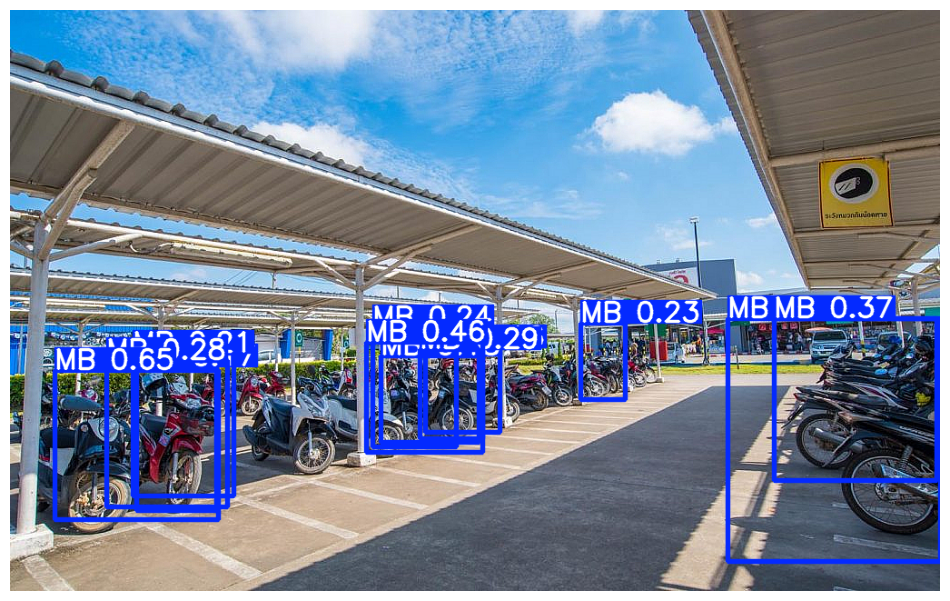

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))
image_rgb_yolo_plot = cv2.cvtColor(image_with_yolo_detections_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb_yolo_plot)
plt.axis('off')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(detected_centers_np)
cluster_centers = kmeans.cluster_centers_

print(f"\n--- Resultados da Clusteriza√ß√£o para {NUM_CLUSTERS} Clusters ---")
for i in range(NUM_CLUSTERS):
    print(f"Zona Sugerida {i+1} (Centroide): X={cluster_centers[i,0]:.0f}, Y={cluster_centers[i,1]:.0f}")
print("Labels dos clusters para cada moto:\n", cluster_labels)


--- Resultados da Clusteriza√ß√£o para 3 Clusters ---
Zona Sugerida 1 (Centroide): X=500, Y=417
Zona Sugerida 2 (Centroide): X=172, Y=469
Zona Sugerida 3 (Centroide): X=919, Y=452
Labels dos clusters para cada moto:
 [1 0 2 2 0 1 0 0 1 0 1 0]


Utilizamos o K-Means para analisar a dispers√£o das motos e sugerir centr√≥ides

<ipython-input-61-664934c1a1c7>:14: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


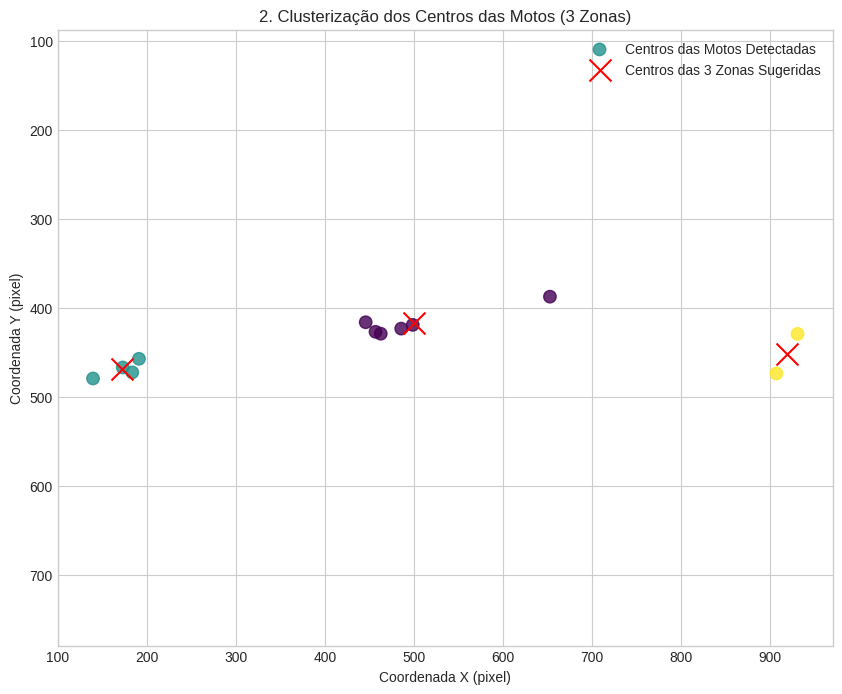

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 8))

plt.scatter(
    detected_centers_np[:, 0],
    detected_centers_np[:, 1],
    c=cluster_labels,
    cmap='viridis',
    s=80,
    alpha=0.8,
    label='Centros das Motos Detectadas'
)

plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c='red',
    marker='x',
    s=250,
    linewidth=1.5,
    label=f'Centros das {NUM_CLUSTERS} Zonas Sugeridas'
)

plt.title(f'2. Clusteriza√ß√£o dos Centros das Motos ({NUM_CLUSTERS} Zonas)')
plt.xlabel("Coordenada X (pixel)")
plt.ylabel("Coordenada Y (pixel)")
plt.legend(loc='best')
plt.grid(True)
plt.gca().invert_yaxis()
plt.axis('equal')
plt.show()

E por fim, apenas uma visualiza√ß√£o simples dos centr√≥ides na imagem

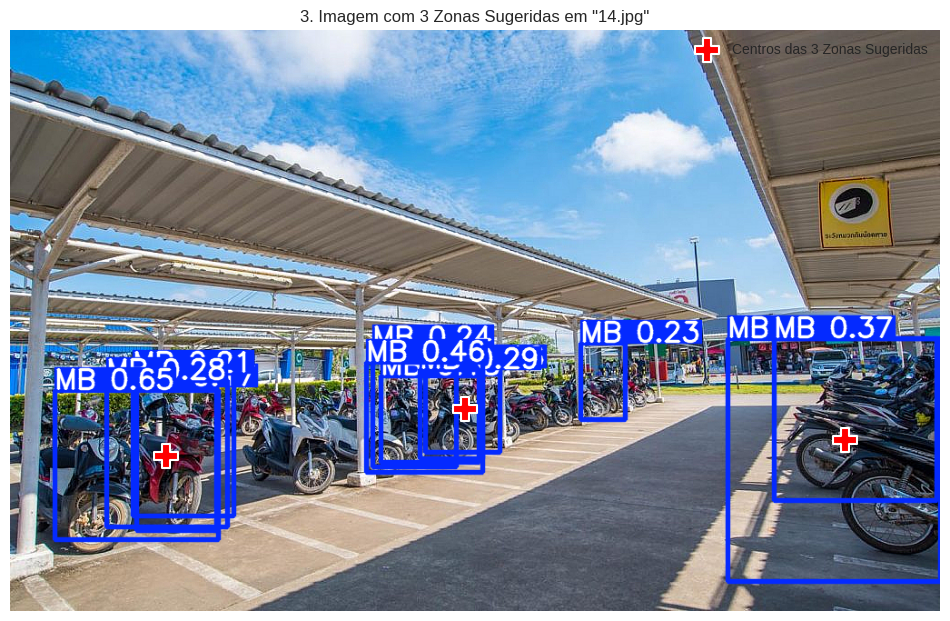

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 10))
image_rgb_yolo_plot_for_zones = cv2.cvtColor(image_with_yolo_detections_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb_yolo_plot_for_zones)

plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    c='red',
    marker='P',
    s=300,
    edgecolor='white',
    linewidth=1.5,
    label=f'Centros das {NUM_CLUSTERS} Zonas Sugeridas'
)

plt.title(f'3. Imagem com {NUM_CLUSTERS} Zonas Sugeridas em "{IMAGE_TO_ANALYZE}"')
plt.legend(loc='best')
plt.axis('off')
plt.show()

## Fine Tuning (TO-DO - 2 entrega)

In [ ]:
NEW_EXPERIMENT_NAME = 'yolov8n_motorbike_finetune_run2_added_data'
NUM_EPOCHS_FINETUNE = 30
LEARNING_RATE_FINETUNE = 0.0005 # auto

In [ ]:
!yolo train model="{path_to_best_pt}" \
            data="{data_yaml_path}" \
            epochs={NUM_EPOCHS_FINETUNE} \
            imgsz=640 \
            batch=16 \
            project="{trained_models_dir}" \
            name="{NEW_EXPERIMENT_NAME}" \
            lr0={LEARNING_RATE_FINETUNE}
            # optimizer='auto'

Ultralytics 8.3.144 üöÄ Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Colab_Notebooks/fleet_cv/datasets/yolo_motorcycle_detector/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Colab_Notebooks/fleet_cv/trained_models/yolo_detector/yolov8n_motorbike_detector_run1/weights/best.pt, momentum=0.937, mosaic=